# Sleep-time Compute Implementation to Optimize LLM Latency

This notebook implements Sleep-time Compute using Mistral-7B-Instruct-v0.1, based on the paper "Sleep-time Compute: Beyond Inference Scaling at Test-time".

## Setup and Installation

First, let's install the required dependencies:

In [1]:
!pip install transformers torch datasets matplotlib tqdm accelerate psutil

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 112.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [35]:
import torch
import re
import json
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
import psutil
import gc
import math

In [3]:
# Utility functions for tracking GPU memory and time
def get_gpu_memory():
    """Returns GPU memory usage in MB"""
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        return torch.cuda.memory_allocated() / 1024**2
    return 0

def get_ram_memory():
    """Returns RAM usage in MB"""
    return psutil.Process().memory_info().rss / 1024**2

## Set Up Mistral Model

Let's set up the Mistral-7B-Instruct-v0.1 model using the requested code:

In [ ]:
# Set your Hugging Face token here (if needed)
HF_TOKEN = "" # Add your Hugging Face token if needed

# Clear GPU cache before loading model
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()

# Model setup
print("Loading Mistral-7B-Instruct-v0.1...")
model_name = "mistralai/Mistral-7B-Instruct-v0.1"

base_memory = get_gpu_memory()
load_start_time = time.time()

if HF_TOKEN:
    tokenizer = AutoTokenizer.from_pretrained(model_name, token=HF_TOKEN, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        device_map="auto",
        trust_remote_code=True,
        token=HF_TOKEN
    )
else:
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        device_map="auto",
        trust_remote_code=True
    )

load_time = time.time() - load_start_time
model_memory = get_gpu_memory() - base_memory

print(f"Model loaded on device: {model.device}")
print(f"Loading time: {load_time:.2f} seconds")
print(f"GPU memory used by model: {model_memory:.2f} MB")

## Implement Sleep-time Compute with Mistral-Specific Prompts

Now, let's implement our Sleep-time Compute functions with prompts tailored for Mistral's instruction format.

In [52]:
# Define Mistral-specific prompt formats
def get_sleep_time_prompt(context):
    """Generate the prompt for the sleep-time phase, formatted for Mistral"""
    return f"""<s>[INST] You are an expert reasoning system. Given a context, your task is to think about the context and make useful inferences, calculations, and predictions that could help answer potential future questions about this context.

For example, if the context involves numbers, calculate relevant quantities. If it involves a scenario, think about different aspects of the scenario that might be important. Try to anticipate possible questions and prepare the information needed to answer them quickly.

Context: {context}

Think step by step and be thorough. Generate a comprehensive set of inferences, calculations, and observations about this context that would be helpful for answering potential questions: [/INST]
"""

def get_test_time_prompt(context, question, inferences, verbosity):
    """Generate the prompt for the test-time phase with variable verbosity, formatted for Mistral"""
    # Base on verbosity level
    if verbosity == 0:
        instruction = "Answer directly with a single sentence. Say 'The answer is' followed by the numerical answer."
    elif verbosity == 1:
        instruction = "Provide one short sentence of explanation, followed by a sentence that starts with 'The answer is' and a numerical answer."
    elif verbosity == 2:
        instruction = "Provide two short sentences of explanation, followed by a sentence that starts with 'The answer is' and a numerical answer."
    elif verbosity == 3:
        instruction = "Reason step by step and provide an answer. End with the final numerical answer."
    else: # verbosity == 4
        instruction = "Reason thoroughly step by step, double check your work, and provide a detailed explanation leading to the answer. End with 'The answer is' followed by the numerical answer."

    return f"""<s>[INST] You are an expert reasoning system. {instruction}

Original Context: {context}

Pre-computed analysis:
{inferences}

Question: {question}

Use the pre-computed analysis to help you answer efficiently. [/INST]
"""

def get_standard_test_time_prompt(context, question, verbosity):
    """Generate the prompt for standard test-time compute, formatted for Mistral"""
    # Base on verbosity level
    if verbosity == 0:
        instruction = "Answer directly with a single sentence. Say 'The answer is' followed by the numerical answer."
    elif verbosity == 1:
        instruction = "Provide one short sentence of explanation, followed by a sentence that starts with 'The answer is' and a numerical answer."
    elif verbosity == 2:
        instruction = "Provide two short sentences of explanation, followed by a sentence that starts with 'The answer is' and a numerical answer."
    elif verbosity == 3:
        instruction = "Reason step by step and provide an answer. End with the final numerical answer."
    else: # verbosity == 4
        instruction = "Reason thoroughly step by step, double check your work, and provide a detailed explanation leading to the answer. End with 'The answer is' followed by the numerical answer."

    return f"""<s>[INST] You are an expert reasoning system. {instruction}

Context and Question: {context} {question} [/INST]
"""

In [51]:
def sleep_time_compute(context, temperature=0.1, max_new_tokens=1024):
    """Perform sleep-time computation on a context using Mistral

    Args:
        context: The context to analyze
        temperature: Temperature for generation
        max_new_tokens: Maximum number of new tokens to generate

    Returns:
        Dictionary with inference text and token count
    """
    prompt = get_sleep_time_prompt(context)

    # Count input tokens
    input_tokens = len(tokenizer.encode(prompt))

    inputs = tokenizer(prompt, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=True if temperature > 0 else False,
            num_return_sequences=1
        )

    # Get generated text, removing the prompt
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=False)

    # Extract the model's response after [/INST]
    response_text = generated_text.split('[/INST]')[-1].strip()
    # Remove any trailing tokens if present
    if "</s>" in response_text:
        response_text = response_text.split("</s>")[0].strip()

    # Count tokens
    sleep_time_tokens = len(tokenizer.encode(response_text))

    return {
        "inferences": response_text,
        "sleep_time_tokens": sleep_time_tokens
    }

In [50]:
def test_time_compute(context, question, inferences, verbosity=0, temperature=0.1, max_new_tokens=512):
    """Perform test-time computation on a context and question using Mistral

    Args:
        context: The context to analyze
        question: The question to answer
        inferences: Pre-computed inferences from sleep-time compute
        verbosity: Verbosity level (0-4)
        temperature: Temperature for generation
        max_new_tokens: Maximum number of new tokens to generate

    Returns:
        Generated response and token count
    """
    prompt = get_test_time_prompt(context, question, inferences, verbosity)

    inputs = tokenizer(prompt, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=True if temperature > 0 else False,
            num_return_sequences=1
        )

    # Get generated text, removing the prompt
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=False)

    # Extract the model's response after [/INST]
    response_text = generated_text.split('[/INST]')[-1].strip()
    # Remove any trailing tokens if present
    if "</s>" in response_text:
        response_text = response_text.split("</s>")[0].strip()

    # Count tokens
    test_time_tokens = len(tokenizer.encode(response_text))

    return {
        "response": response_text,
        "test_time_tokens": test_time_tokens
    }

In [49]:
def standard_test_time_compute(context, question, verbosity=0, temperature=0.1, max_new_tokens=512):
    """Perform standard test-time computation without sleep-time compute using Mistral

    Args:
        context: The context to analyze
        question: The question to answer
        verbosity: Verbosity level (0-4)
        temperature: Temperature for generation
        max_new_tokens: Maximum number of new tokens to generate

    Returns:
        Generated response and token count
    """
    prompt = get_standard_test_time_prompt(context, question, verbosity)

    inputs = tokenizer(prompt, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=True if temperature > 0 else False,
            num_return_sequences=1
        )

    # Get generated text, removing the prompt
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=False)

    # Extract the model's response after [/INST]
    response_text = generated_text.split('[/INST]')[-1].strip()
    # Remove any trailing tokens if present
    if "</s>" in response_text:
        response_text = response_text.split("</s>")[0].strip()

    # Count tokens
    test_time_tokens = len(tokenizer.encode(response_text))

    return {
        "response": response_text,
        "test_time_tokens": test_time_tokens
    }

## Helper Functions for Evaluation

In [10]:
def extract_answer(response_content):
    """Extract a numerical answer from response content"""
    # Look for "answer is X" pattern
    match = re.search(r'[Tt]he answer is (\d+)', response_content)
    if match:
        return match.group(1)

    # Look for a number at the end of the response
    match = re.search(r'(\d+)\s*\.?\s*$', response_content)
    if match:
        return match.group(1)

    # Just extract any number in the response (less reliable)
    numbers = re.findall(r'\b(\d+)\b', response_content)
    if numbers:
        return numbers[-1]  # Often the last number is the answer

    return None

## Example Sleep-time and Test-time Outputs

Let's look at an example of what happens during the sleep-time and test-time phases for one of our problems.

In [46]:
# Define multiple questions for the same context
multi_query_example = {
    "context": "A juggler can juggle 800 balls. 1/4 of the balls are tennis balls, and 1/2 of the tennis balls are indigo of which 1/10 are marked. The rest of the balls are golf balls, of which 3/4 are blue and the remainder are yellow.",
    "questions": [
        {"question": "How many marked indigo tennis balls are there?", "answer": "10"},
        {"question": "How many tennis balls are there in total?", "answer": "200"},
        {"question": "How many golf balls are there?", "answer": "600"},
        {"question": "How many blue golf balls are there?", "answer": "450"},
        {"question": "How many yellow golf balls are there?", "answer": "150"}
    ]
}

In [60]:
def demonstrate_multi_query(example):
    """Demonstrate the amortization of sleep-time compute across multiple queries with focused visualizations"""
    import matplotlib.pyplot as plt
    import numpy as np
    import time
    import math

    context = example["context"]
    questions = example["questions"]

    print("\nContext:")
    print(context)

    # Sleep-time phase (only done once)
    print("\n=== SLEEP-TIME PHASE (Done once per context) ===")
    sleep_start = time.time()
    sleep_time_result = sleep_time_compute(context, temperature=0)
    sleep_time = time.time() - sleep_start
    print(f"Sleep-time tokens: {sleep_time_result['sleep_time_tokens']}")
    print(f"Sleep-time computation: {sleep_time:.2f} seconds")
    print("Sleep-time inferences:")
    print(sleep_time_result["inferences"][:500] + "..." if len(sleep_time_result["inferences"]) > 500 else sleep_time_result["inferences"])

    sleep_time_tokens = sleep_time_result["sleep_time_tokens"]

    # Track metrics for each approach
    standard_results = []
    sleep_test_results = []

    # Test-time phase (for each query)
    print("\n=== TEST-TIME PHASE (For multiple queries) ===")
    for i, q in enumerate(questions):
        question = q["question"]
        expected_answer = q["answer"]
        print(f"\nQuery {i+1}: {question}")

        # Standard approach (for comparison)
        std_start = time.time()
        standard_result = standard_test_time_compute(context, question, verbosity=1, temperature=0)
        std_time = time.time() - std_start
        standard_tokens = standard_result["test_time_tokens"]
        extracted_std_answer = extract_answer(standard_result["response"])
        std_correct = extracted_std_answer == expected_answer

        standard_results.append({
            "tokens": standard_tokens,
            "time": std_time,
            "correct": std_correct,
            "extracted_answer": extracted_std_answer,
            "question": question,
            "expected": expected_answer
        })

        print(f"Standard approach answer: {extracted_std_answer} (Expected: {expected_answer}, Correct: {std_correct})")
        print(f"Standard tokens: {standard_tokens}")
        print(f"Standard computation time: {std_time:.2f} seconds")

        # Sleep-time approach
        test_start = time.time()
        test_time_result = test_time_compute(
            context, question, sleep_time_result["inferences"], verbosity=1, temperature=0
        )
        test_time = time.time() - test_start
        sleep_test_tokens = test_time_result["test_time_tokens"]
        extracted_sleep_answer = extract_answer(test_time_result["response"])
        sleep_correct = extracted_sleep_answer == expected_answer

        sleep_test_results.append({
            "tokens": sleep_test_tokens,
            "time": test_time,
            "correct": sleep_correct,
            "extracted_answer": extracted_sleep_answer,
            "question": question,
            "expected": expected_answer
        })

        print(f"Sleep-time approach answer: {extracted_sleep_answer} (Expected: {expected_answer}, Correct: {sleep_correct})")
        print(f"Sleep-time test tokens: {sleep_test_tokens}")
        print(f"Sleep-time test computation time: {test_time:.2f} seconds")
        print(f"Time speedup for this query: {std_time/test_time:.2f}x")

    # Calculate aggregate metrics
    total_standard_tokens = sum(r["tokens"] for r in standard_results)
    total_standard_time = sum(r["time"] for r in standard_results)
    standard_accuracy = sum(1 for r in standard_results if r["correct"]) / len(standard_results)

    total_sleep_test_tokens = sum(r["tokens"] for r in sleep_test_results)
    total_sleep_test_time = sum(r["time"] for r in sleep_test_results)
    sleep_accuracy = sum(1 for r in sleep_test_results if r["correct"]) / len(sleep_test_results)

    avg_standard_tokens = total_standard_tokens / len(questions)
    avg_standard_time = total_standard_time / len(questions)
    avg_sleep_test_tokens = total_sleep_test_tokens / len(questions)
    avg_sleep_test_time = total_sleep_test_time / len(questions)

    # Calculate the amortization benefit
    print("\n=== AMORTIZATION SUMMARY ===")
    print(f"Number of queries in this test: {len(questions)}")
    print(f"Standard approach accuracy: {standard_accuracy:.2%}")
    print(f"Sleep-time approach accuracy: {sleep_accuracy:.2%}")

    print("\n--- Current Performance ---")
    print(f"Total tokens with standard approach: {total_standard_tokens}")
    print(f"Total tokens with sleep-time approach: {sleep_time_tokens + total_sleep_test_tokens}")

    current_token_factor = total_standard_tokens / (sleep_time_tokens + total_sleep_test_tokens)
    print(f"Current token efficiency: {current_token_factor:.2f}x")

    print(f"\nTotal computation time with standard approach: {total_standard_time:.2f} seconds")
    print(f"Total computation time with sleep-time approach: {sleep_time + total_sleep_test_time:.2f} seconds")

    current_time_factor = total_standard_time / (sleep_time + total_sleep_test_time)
    print(f"Current time efficiency: {current_time_factor:.2f}x")

    # Calculate the break-even point
    if avg_sleep_test_time >= avg_standard_time:
        break_even_time = float('inf')
        print("\nSleep-time compute will never break even for time in this workload.")
    else:
        break_even_time = sleep_time / (avg_standard_time - avg_sleep_test_time)
        print(f"\n--- Break-Even Analysis ---")
        print(f"Time break-even point: {math.ceil(break_even_time)} queries")
        print(f"After {math.ceil(break_even_time)} queries, sleep-time compute becomes faster overall.")

    if avg_sleep_test_tokens >= avg_standard_tokens:
        break_even_tokens = float('inf')
        print("Sleep-time compute will never break even for tokens in this workload.")
    else:
        break_even_tokens = sleep_time_tokens / (avg_standard_tokens - avg_sleep_test_tokens)
        print(f"Token break-even point: {math.ceil(break_even_tokens)} queries")
        print(f"After {math.ceil(break_even_tokens)} queries, sleep-time compute becomes token-efficient.")

    # Project performance with more queries
    print("\n--- Projected Performance ---")
    print("Number of queries | Token Efficiency | Time Efficiency")
    print("--------------------------------------------------")

    query_counts = [10, 25, 50, 100, 250, 500, 1000]
    token_efficiencies = []
    time_efficiencies = []

    for num_queries in query_counts:
        # Calculate projected metrics
        proj_standard_tokens = avg_standard_tokens * num_queries
        proj_sleep_tokens = sleep_time_tokens + (avg_sleep_test_tokens * num_queries)
        proj_token_factor = proj_standard_tokens / proj_sleep_tokens
        token_efficiencies.append(proj_token_factor)

        proj_standard_time = avg_standard_time * num_queries
        proj_sleep_time = sleep_time + (avg_sleep_test_time * num_queries)
        proj_time_factor = proj_standard_time / proj_sleep_time
        time_efficiencies.append(proj_time_factor)

        print(f"{num_queries:14d} | {proj_token_factor:15.2f}x | {proj_time_factor:14.2f}x")

    # Performance per query (not including sleep-time cost)
    print("\n--- Per-Query Performance (excluding setup) ---")
    print(f"Standard approach: {avg_standard_tokens:.1f} tokens, {avg_standard_time:.2f} seconds per query")
    print(f"Sleep-time approach: {avg_sleep_test_tokens:.1f} tokens, {avg_sleep_test_time:.2f} seconds per query")
    print(f"Per-query token reduction: {avg_standard_tokens / avg_sleep_test_tokens:.2f}x")
    print(f"Per-query time speedup: {avg_standard_time / avg_sleep_test_time:.2f}x")

    # VISUALIZATION 1: Cumulative computation time (excluding setup time)
    plt.figure(figsize=(10, 6))

    # Calculate cumulative computation times
    cum_std_times = np.cumsum([r["time"] for r in standard_results])
    cum_sleep_times = np.cumsum([r["time"] for r in sleep_test_results])

    # Plot the cumulative times
    plt.plot(range(1, len(questions) + 1), cum_std_times, 'b-', linewidth=2, label='Standard Test-time Compute')
    plt.plot(range(1, len(questions) + 1), cum_sleep_times, 'g-', linewidth=2, label='Sleep-time Test Phase Only')

    # Shade the area between curves to show savings
    if np.any(cum_std_times > cum_sleep_times):
        plt.fill_between(
            range(1, len(questions) + 1),
            cum_std_times,
            cum_sleep_times,
            where=(cum_std_times > cum_sleep_times),
            color='green', alpha=0.3, label='Time Savings'
        )

    plt.title('Cumulative Computation Time (Test-time Phase Only)', fontsize=14)
    plt.xlabel('Number of Queries', fontsize=12)
    plt.ylabel('Total Time (seconds)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.savefig('cumulative_test_time.png', dpi=300)

    print("\n✅ Cumulative computation time visualization saved to 'cumulative_test_time.png'")

    # VISUALIZATION 2: Test-time compute vs. Accuracy
    # Generate data for different verbosity levels
    verbosity_levels = [0, 1, 2, 3]
    std_tokens = []
    std_accs = []
    sleep_tokens = []
    sleep_accs = []

    # Use a subset of questions for testing different verbosity levels
    sample_size = min(5, len(questions))
    sample_questions = questions[:sample_size]

    print(f"\nGenerating test-time compute vs. accuracy graph (using {sample_size} sample questions)...")

    for verbosity in verbosity_levels:
        # Standard approach
        std_correct = 0
        std_token_sum = 0

        for q in sample_questions:
            result = standard_test_time_compute(context, q["question"], verbosity=verbosity, temperature=0)
            std_token_sum += result["test_time_tokens"]
            answer = extract_answer(result["response"])
            if answer == q["answer"]:
                std_correct += 1

        std_tokens.append(std_token_sum / len(sample_questions))
        std_accs.append(std_correct / len(sample_questions) * 100)

        # Sleep-time approach
        sleep_correct = 0
        sleep_token_sum = 0

        for q in sample_questions:
            result = test_time_compute(context, q["question"],
                                     sleep_time_result["inferences"],
                                     verbosity=verbosity, temperature=0)
            sleep_token_sum += result["test_time_tokens"]
            answer = extract_answer(result["response"])
            if answer == q["answer"]:
                sleep_correct += 1

        sleep_tokens.append(sleep_token_sum / len(sample_questions))
        sleep_accs.append(sleep_correct / len(sample_questions) * 100)

        print(f"  Verbosity {verbosity} complete")

    plt.figure(figsize=(10, 6))

    # Plot the pareto curves
    plt.plot(std_tokens, std_accs, 'bo-', linewidth=2, markersize=8, label='Standard Test-time Compute')
    plt.plot(sleep_tokens, sleep_accs, 'go-', linewidth=2, markersize=8, label='Sleep-time Compute')

    # Annotate verbosity levels
    for i, (x, y) in enumerate(zip(std_tokens, std_accs)):
        plt.annotate(f"V{verbosity_levels[i]}", (x, y), xytext=(5, -15),
                     textcoords='offset points', fontsize=9, color='blue')

    for i, (x, y) in enumerate(zip(sleep_tokens, sleep_accs)):
        plt.annotate(f"V{verbosity_levels[i]}", (x, y), xytext=(5, 10),
                     textcoords='offset points', fontsize=9, color='green')

    # Shade the pareto improvement area
    max_sleep_acc = max(sleep_accs)
    plt.fill_between([min(std_tokens + sleep_tokens) * 0.9, max(std_tokens + sleep_tokens) * 1.1],
                   0, max_sleep_acc, alpha=0.1, color='green')

    plt.title('Test-time Compute vs. Accuracy', fontsize=14)
    plt.xlabel('Avg. Test-time Tokens / Query', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.savefig('test_time_vs_accuracy.png', dpi=300)

    print("✅ Test-time compute vs. accuracy visualization saved to 'test_time_vs_accuracy.png'")

    return {
        "standard_results": standard_results,
        "sleep_test_results": sleep_test_results,
        "standard_accuracy": standard_accuracy,
        "sleep_accuracy": sleep_accuracy,
        "avg_standard_tokens": avg_standard_tokens,
        "avg_sleep_test_tokens": avg_sleep_test_tokens,
        "avg_standard_time": avg_standard_time,
        "avg_sleep_test_time": avg_sleep_test_time,
        "break_even_time": break_even_time if 'break_even_time' in locals() else None,
        "break_even_tokens": break_even_tokens if 'break_even_tokens' in locals() else None
    }

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Context:
A juggler can juggle 800 balls. 1/4 of the balls are tennis balls, and 1/2 of the tennis balls are indigo of which 1/10 are marked. The rest of the balls are golf balls, of which 3/4 are blue and the remainder are yellow.

=== SLEEP-TIME PHASE (Done once per context) ===


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Sleep-time tokens: 1026
Sleep-time computation: 43.64 seconds
Sleep-time inferences:
1. The juggler can juggle 800 balls, which means there are 800 balls in total.
2. 1/4 of the balls are tennis balls, so there are 800 x 1/4 = 200 tennis balls.
3. 1/2 of the tennis balls are indigo, so there are 200 x 1/2 = 100 indigo tennis balls.
4. 1/10 of the indigo tennis balls are marked, so there are 100 x 1/10 = 10 marked indigo tennis balls.
5. The rest of the balls are golf balls, which means there are 800 - 200 = 600 golf balls.
6. 3/4 of the golf balls are blue, so there are 600 x 3/...

=== TEST-TIME PHASE (For multiple queries) ===

Query 1: How many marked indigo tennis balls are there?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Standard approach answer: 8 (Expected: 10, Correct: False)
Standard tokens: 40
Standard computation time: 1.63 seconds


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Sleep-time approach answer: 10 (Expected: 10, Correct: True)
Sleep-time test tokens: 8
Sleep-time test computation time: 0.44 seconds
Time speedup for this query: 3.71x

Query 2: How many tennis balls are there in total?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Standard approach answer: 16 (Expected: 200, Correct: False)
Standard tokens: 42
Standard computation time: 1.73 seconds


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Sleep-time approach answer: 100 (Expected: 200, Correct: False)
Sleep-time test tokens: 22
Sleep-time test computation time: 0.99 seconds
Time speedup for this query: 1.75x

Query 3: How many golf balls are there?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Standard approach answer: 200 (Expected: 600, Correct: False)
Standard tokens: 44
Standard computation time: 1.77 seconds


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Sleep-time approach answer: 600 (Expected: 600, Correct: True)
Sleep-time test tokens: 9
Sleep-time test computation time: 0.48 seconds
Time speedup for this query: 3.71x

Query 4: How many blue golf balls are there?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Standard approach answer: 375 (Expected: 450, Correct: False)
Standard tokens: 195
Standard computation time: 7.99 seconds


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Sleep-time approach answer: 450 (Expected: 450, Correct: True)
Sleep-time test tokens: 9
Sleep-time test computation time: 0.49 seconds
Time speedup for this query: 16.20x

Query 5: How many yellow golf balls are there?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Standard approach answer: 200 (Expected: 150, Correct: False)
Standard tokens: 44
Standard computation time: 1.93 seconds
Sleep-time approach answer: 150 (Expected: 150, Correct: True)
Sleep-time test tokens: 9
Sleep-time test computation time: 0.49 seconds
Time speedup for this query: 3.91x

=== AMORTIZATION SUMMARY ===
Number of queries in this test: 5
Standard approach accuracy: 0.00%
Sleep-time approach accuracy: 80.00%

--- Current Performance ---
Total tokens with standard approach: 365
Total tokens with sleep-time approach: 1083
Current token efficiency: 0.34x

Total computation time with standard approach: 15.06 seconds
Total computation time with sleep-time approach: 46.53 seconds
Current time efficiency: 0.32x

--- Break-Even Analysis ---
Time break-even point: 18 queries
After 18 queries, sleep-time compute becomes faster overall.
Token break-even point: 17 queries
After 17 queries, sleep-time compute becomes token-efficient.

--- Projected Performance ---
Number of queries 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



✅ Cumulative computation time visualization saved to 'cumulative_test_time.png'

Generating test-time compute vs. accuracy graph (using 5 sample questions)...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


  Verbosity 0 complete


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


  Verbosity 1 complete


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


  Verbosity 2 complete


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


  Verbosity 3 complete
✅ Test-time compute vs. accuracy visualization saved to 'test_time_vs_accuracy.png'


{'standard_results': [{'tokens': 40,
   'time': 1.6317694187164307,
   'correct': False,
   'extracted_answer': '8',
   'question': 'How many marked indigo tennis balls are there?',
   'expected': '10'},
  {'tokens': 42,
   'time': 1.7310221195220947,
   'correct': False,
   'extracted_answer': '16',
   'question': 'How many tennis balls are there in total?',
   'expected': '200'},
  {'tokens': 44,
   'time': 1.7725911140441895,
   'correct': False,
   'extracted_answer': '200',
   'question': 'How many golf balls are there?',
   'expected': '600'},
  {'tokens': 195,
   'time': 7.994421482086182,
   'correct': False,
   'extracted_answer': '375',
   'question': 'How many blue golf balls are there?',
   'expected': '450'},
  {'tokens': 44,
   'time': 1.925654411315918,
   'correct': False,
   'extracted_answer': '200',
   'question': 'How many yellow golf balls are there?',
   'expected': '150'}],
 'sleep_test_results': [{'tokens': 8,
   'time': 0.4393348693847656,
   'correct': True,
 

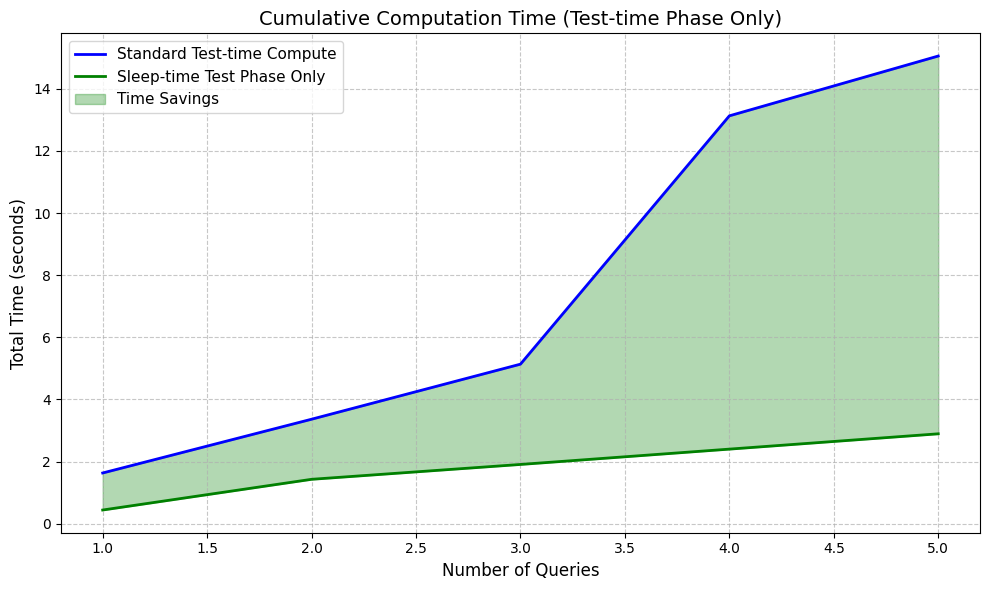

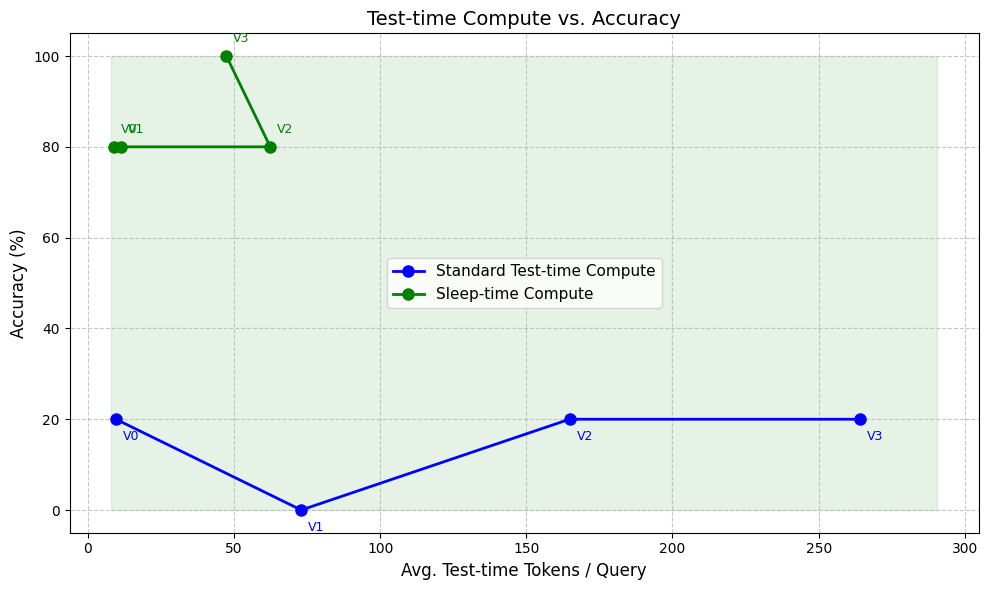

In [61]:
# Demonstrate multi-query amortization
demonstrate_multi_query(multi_query_example)